# Case Study : Grovers Algorithm

In [1]:
# Built-in modules
import math
from math import log2
import numpy as np

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, errors
from qiskit.primitives import StatevectorSampler
from qiskit import transpile
from qiskit_aer.noise import depolarizing_error

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService


import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

In [2]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        
        qc.x(zero_inds)      # Line 1
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)    # Line 2
        qc.x(zero_inds)      # line 3
    return qc

In [3]:

def grover_search(marked_states, shots=100000, noise=None):
    oracle = grover_oracle(marked_states)
    grover_op = GroverOperator(oracle)

    optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
    )
    
    qc = QuantumCircuit(grover_op.num_qubits)
    # Create even superposition of all basis states
    qc.h(range(grover_op.num_qubits))
    # Apply Grover operator the optimal number of times
    qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
    # Measure all qubits
    qc.measure_all()
    
    sampler = AerSimulator(method='statevector', noise_model=noise)
    target = sampler.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)

    circuit_isa = pm.run(qc)

    # Decompose the circuit
    circuit_isa = circuit_isa.decompose(reps=10)
    result = sampler.run(circuit_isa, shots=shots, memory=True).result()
    return result.get_counts(), circuit_isa

In [4]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

from qiskit_aer.noise import NoiseModel, depolarizing_error

def create_noise_model(p):
    noise_model = NoiseModel()

    error = depolarizing_error(4*p/3, 1)
    noise_model.add_all_qubit_quantum_error(error, ['id', 'u', 'u1', 'u2', 'u3', 'rz', 'sx', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg'])
    
    error = depolarizing_error(16*p/15, 2)
    noise_model.add_all_qubit_quantum_error(error, ['cx'])
    
    return noise_model

In [5]:
def calculate_bias_entropy(output_map, marked_state):
    total_count = sum(output_map.values())

    bias = 0
    count = 0
    for key, val in output_map.items():
        if key not in marked_state:
            bias += val / total_count
        count += 1

    entropy = 0
    for key, val in output_map.items():
        if (val == 0):
            continue
        else:
            p = val / total_count
            entropy = entropy - p * log2(p)

    return bias, entropy

In [6]:
def to_bin(number, num_bits):
    return format(number, f'0{num_bits}b')

In [7]:
def empty_dict(n):
    dict = {}
    keys = [to_bin(i,n) for i in range(pow(2,n))]
    dict = dict.fromkeys(keys, 0)
    return dict 

In [8]:
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)

Let us consider a quantum program whose desired state is : {000}
When this program is run, one would expect that we get this state with probability 1 and the other states with probability 0.

OrderedDict([('u', 51), ('cx', 24), ('measure', 3), ('barrier', 1)])
bias is 0.04699999999999999
entropy is 0.4005502228365641
{'000': 953, '001': 12, '010': 9, '011': 5, '100': 5, '101': 7, '110': 4, '111': 5}


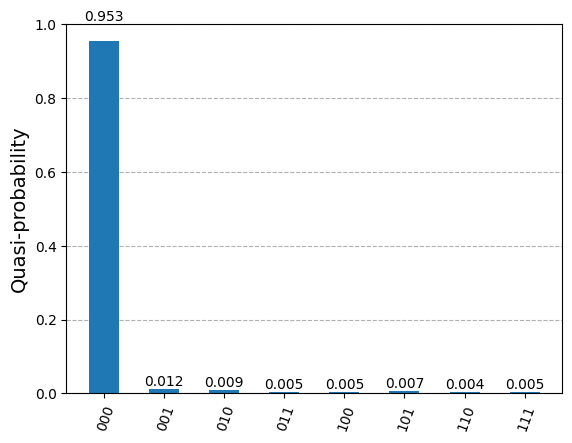

In [25]:
marked_states=['000']
shots = 1000000

dist = empty_dict(len(marked_states[0]))
result, circuit = grover_search(marked_states, shots=1000, noise=None)
print(circuit.count_ops())
for key, val in result.items():
    dist[key] = val

bias, entropy = calculate_bias_entropy(dist, marked_states)

print(f"bias is {bias}")
print(f"entropy is {entropy}")

print(dist)

fig, ax = plt.subplots()
plot_distribution(dist, ax=ax)
ax.set_ylim(0, 1)  # Force y-axis to be within 0 and 1
plt.show()

However, in reality, this does not happen. In quantum computers, there is a large influence of noise, which may cause bug-like effct even when the algorithm is written correctly. This is called noise. Due to such noisy behavior in quantum computers, we may get results of the following manner:

OrderedDict([('u', 387), ('cx', 96), ('measure', 3), ('barrier', 1)])
bias is 0.11000000000000001
entropy is 0.7571522718995755
{'000': 890, '001': 41, '010': 26, '011': 5, '100': 20, '101': 9, '110': 6, '111': 3}


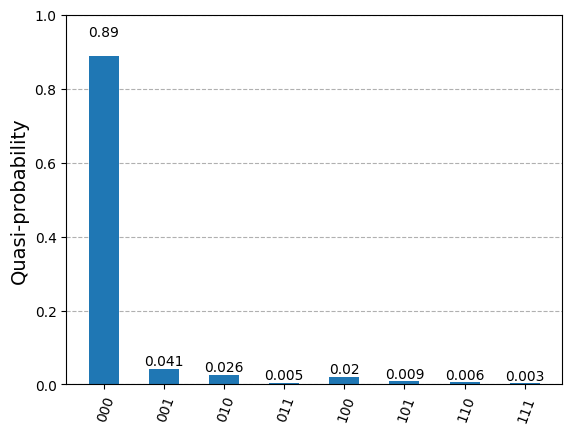

In [ ]:
marked_states=['000']
shots = 1000000

dist = empty_dict(len(marked_states[0]))
result, circuit = grover_search(marked_states, shots=1000, noise=noise_model)
print(circuit.count_ops())
for key, val in result.items():
    dist[key] = val

bias, entropy = calculate_bias_entropy(dist, marked_states)

print(f"bias is {bias}")
print(f"entropy is {entropy}")

print(dist)

fig, ax = plt.subplots()
plot_distribution(dist, ax=ax)
ax.set_ylim(0, 1)  # Force y-axis to be within 0 and 1
plt.show()

We can clearly see the difference of percentge of correct answers (88.1%) in precence of noise v/s without noise (94.5%). This affect may seem small and irrelevant, noise may not always be 'friendly' or the noise level is below the 'threshold' (Defined later). There may be a case when noise may lead to the following result :

OrderedDict([('u', 39), ('cx', 24), ('measure', 3), ('barrier', 1)])
bias is 0.875
entropy is 2.994983500866772
{'000': 125, '001': 129, '010': 128, '011': 117, '100': 146, '101': 121, '110': 107, '111': 127}


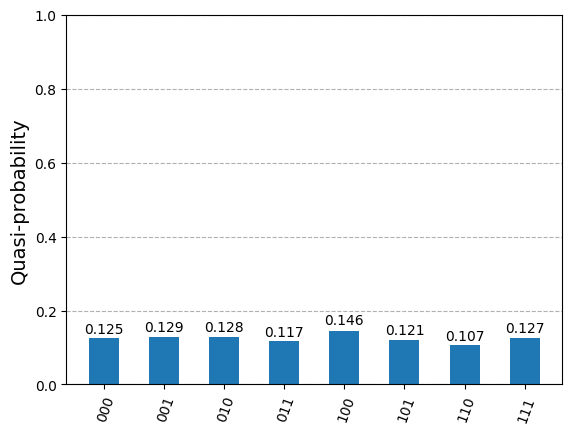

In [30]:
marked_states=['000']
shots = 1000000

noise = create_noise_model(0.1)
dist = empty_dict(len(marked_states[0]))
result, circuit = grover_search(marked_states, shots=1000, noise=noise)
print(circuit.count_ops())
for key, val in result.items():
    dist[key] = val

bias, entropy = calculate_bias_entropy(dist, marked_states)

print(f"bias is {bias}")
print(f"entropy is {entropy}")

print(dist)

fig, ax = plt.subplots()
plot_distribution(dist, ax=ax)
ax.set_ylim(0, 1)  # Force y-axis to be within 0 and 1
plt.show()

When dealing with probabilistic algorithms, one would say that we report the answer as th state which is most proable, i.e. the one with the highest probability. However, due to the effect of noise, the Most Probable state is not same as the Desired State even though the algorithm is correct. We say that here the 'noise level is out of control' or the noise level is above the 'thresold'

Thus by this observation, we say that noise causes increase in entropy. I.e. For a given quantum algorithm (buggy or not buggy), the entropy of the state would increase as long as the initial state of the system is not one where each of the state is a possible and significantly probable state

# Entropy vs Noise : Finding the threshold

Now let us see a case study of how to thereotically measure the thresold.

In [31]:
marked_states=['000', '001']
shots = 10000

biases = []
entropies = []
noise_levels = [j/10000.0 for j in range(0, 400)]
for i in noise_levels:
    # print(i)
    noise = create_noise_model(i)
    result, _ = grover_search(marked_states, shots, noise=noise)

    bias, entropy = calculate_bias_entropy(result, marked_states)
    biases.append(bias)
    entropies.append(entropy)

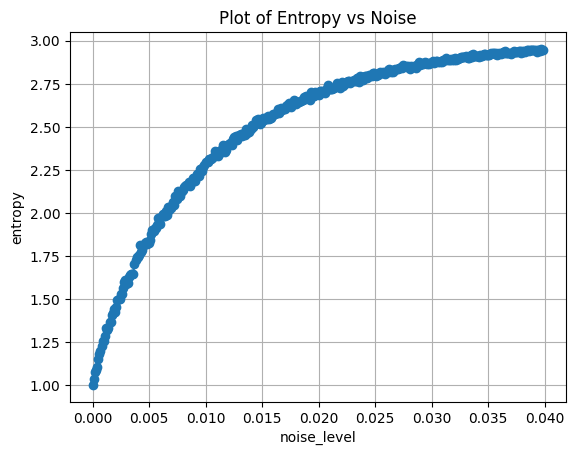

In [32]:
plt.plot(noise_levels, entropies, marker='o')  # marker='o' adds points for each x-y pair
plt.xlabel('noise_level')
plt.ylabel('entropy')
plt.title('Plot of Entropy vs Noise')
plt.grid(True)
plt.show()

(1 - 2 / 2 ^ (3)) * (1/(33+18)) = 0.0147 is thereotical
actual is around 0.04

## Comparing bug and noise

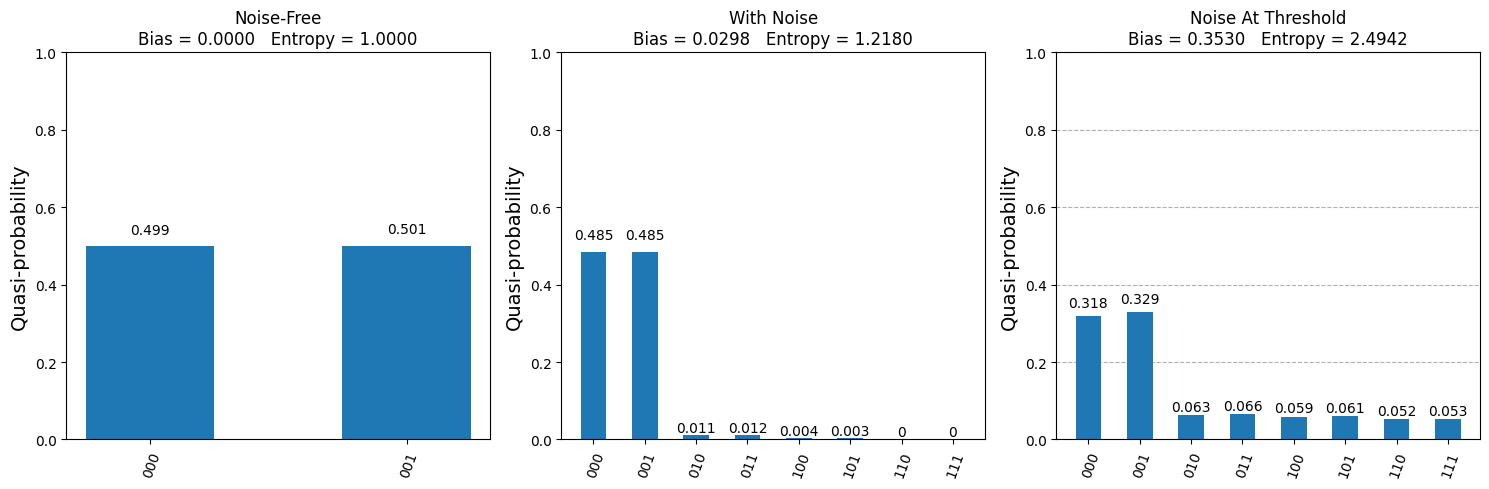

In [33]:
def grover_search(marked_states, shots=100000, noise=None):
    oracle = grover_oracle(marked_states)
    grover_op = GroverOperator(oracle)

    optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
    )
    
    qc = QuantumCircuit(grover_op.num_qubits)
    # Create even superposition of all basis states
    qc.h(range(grover_op.num_qubits))
    # Apply Grover operator the optimal number of times
    qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
    # Measure all qubits
    qc.measure_all()
    
    sampler = AerSimulator(method='statevector', noise_model=noise)
    target = sampler.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)

    circuit_isa = pm.run(qc)
    circuit_isa = circuit_isa.decompose(reps=10)
    result = sampler.run(circuit_isa, shots=shots, memory=True).result()
    return result.get_counts(), circuit_isa

marked_states=['000', '001']
shots = 10000
noise = create_noise_model(0.014)


result, _ = grover_search(marked_states, shots, noise=noise_model)
result_noise_free, _ = grover_search(marked_states, shots, noise=None)
result_noise_thresh, _ = grover_search(marked_states, shots, noise=noise)

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms
plot_distribution(result, ax=axes[1])
bias,entropy=calculate_bias_entropy(result,marked_states)
axes[1].set_title(f"With Noise\nBias = {bias:.4f}   Entropy = {entropy:.4f}")

plot_distribution(result_noise_free, ax=axes[0])
bias,entropy=calculate_bias_entropy(result_noise_free,marked_states)
axes[0].set_title(f"Noise-Free\nBias = {bias:.4f}   Entropy = {entropy:.4f}")

plot_distribution(result_noise_thresh, ax=axes[2])
bias,entropy=calculate_bias_entropy(result_noise_thresh,marked_states)
axes[2].set_title(f"Noise At Threshold\nBias = {bias:.4f}   Entropy = {entropy:.4f}")

axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)
axes[2].set_ylim(0, 1)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

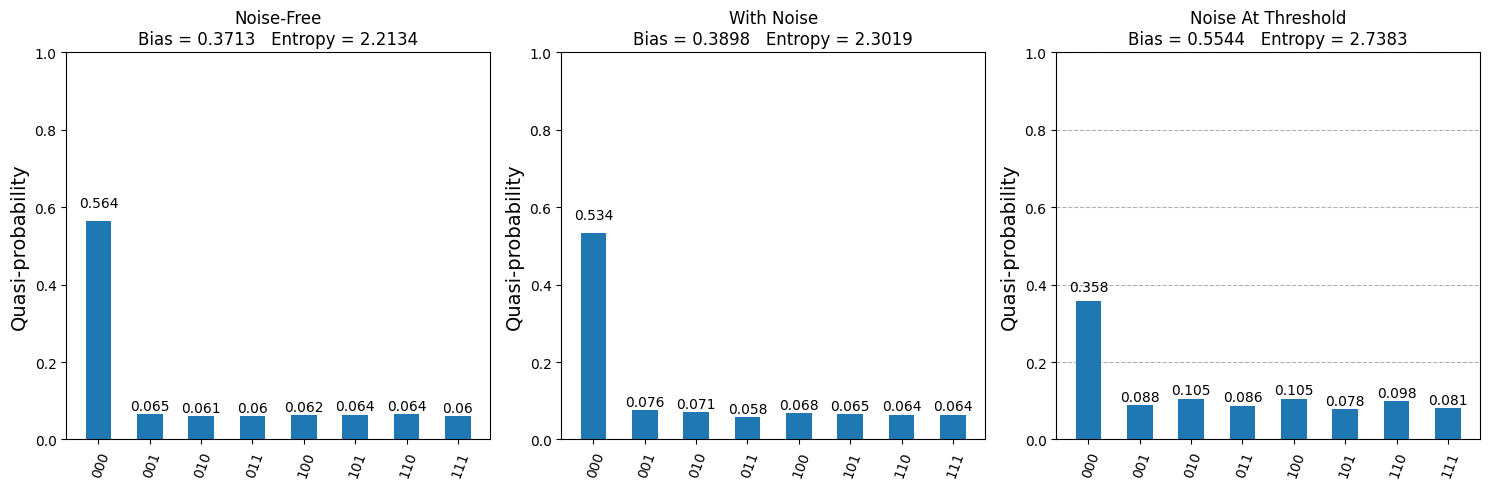

In [34]:
def grover_search(marked_states, shots=100000, noise=None):
    oracle = grover_oracle(marked_states)
    grover_op = GroverOperator(oracle)

    optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
    )
    
    qc = QuantumCircuit(grover_op.num_qubits)
    # Create even superposition of all basis states
    qc.h(range(grover_op.num_qubits))
    qc.h(0)  #bug
    # Apply Grover operator the optimal number of times
    qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
    # Measure all qubits
    qc.measure_all()
    
    sampler = AerSimulator(method='statevector', noise_model=noise)
    target = sampler.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)

    circuit_isa = pm.run(qc)
    circuit_isa = circuit_isa.decompose(reps=10)
    result = sampler.run(circuit_isa, shots=shots, memory=True).result()
    return result.get_counts(), circuit_isa

marked_states=['000', '001']
shots = 10000
noise = create_noise_model(0.014)


result, _ = grover_search(marked_states, shots, noise=noise_model)
result_noise_free, _ = grover_search(marked_states, shots, noise=None)
result_noise_thresh, _ = grover_search(marked_states, shots, noise=noise)

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms
plot_distribution(result, ax=axes[1])
bias,entropy=calculate_bias_entropy(result,marked_states)
axes[1].set_title(f"With Noise\nBias = {bias:.4f}   Entropy = {entropy:.4f}")

plot_distribution(result_noise_free, ax=axes[0])
bias,entropy=calculate_bias_entropy(result_noise_free,marked_states)
axes[0].set_title(f"Noise-Free\nBias = {bias:.4f}   Entropy = {entropy:.4f}")

plot_distribution(result_noise_thresh, ax=axes[2])
bias,entropy=calculate_bias_entropy(result_noise_thresh,marked_states)
axes[2].set_title(f"Noise At Threshold\nBias = {bias:.4f}   Entropy = {entropy:.4f}")

axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)
axes[2].set_ylim(0, 1)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

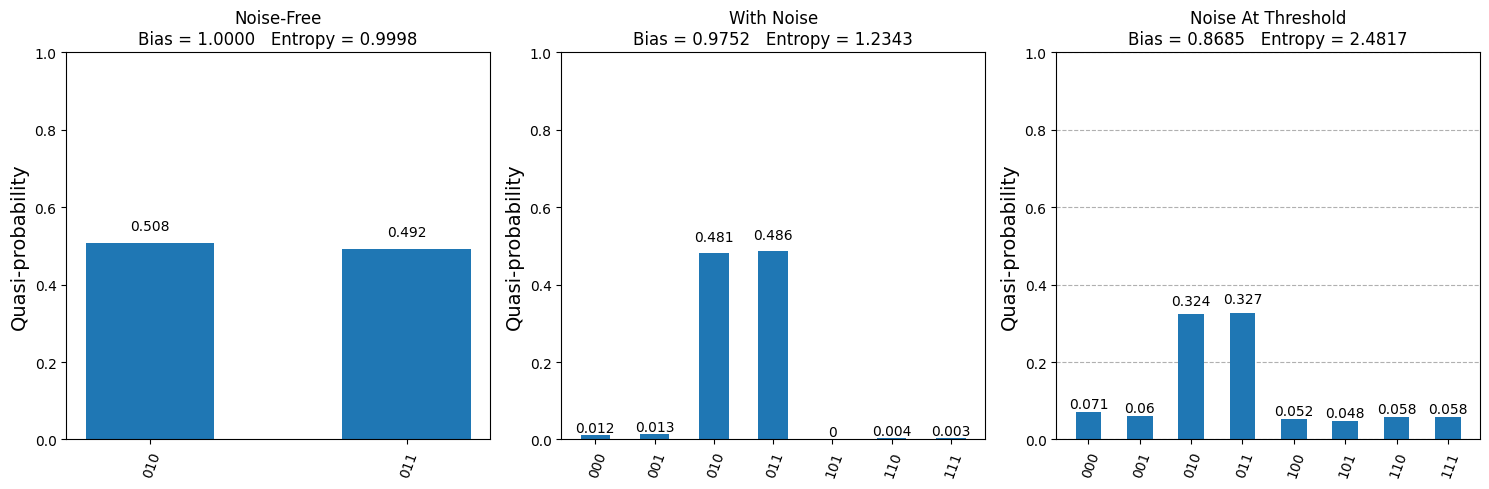

In [35]:
def grover_search(marked_states, shots=100000, noise=None):
    oracle = grover_oracle(marked_states)
    grover_op = GroverOperator(oracle)

    optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
    )
    
    qc = QuantumCircuit(grover_op.num_qubits)
    # Create even superposition of all basis states
    qc.h(range(grover_op.num_qubits))
    qc.y(2) # Bug
    # Apply Grover operator the optimal number of times
    qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
    # Measure all qubits
    qc.measure_all()
    
    sampler = AerSimulator(method='statevector', noise_model=noise)
    target = sampler.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)

    circuit_isa = pm.run(qc)
    circuit_isa = circuit_isa.decompose(reps=10)
    result = sampler.run(circuit_isa, shots=shots, memory=True).result()
    return result.get_counts(), circuit_isa

marked_states=['000', '001']
shots = 10000
noise = create_noise_model(0.014)


result, _ = grover_search(marked_states, shots, noise=noise_model)
result_noise_free, _ = grover_search(marked_states, shots, noise=None)
result_noise_thresh, _ = grover_search(marked_states, shots, noise=noise)

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms
plot_distribution(result, ax=axes[1])
bias,entropy=calculate_bias_entropy(result,marked_states)
axes[1].set_title(f"With Noise\nBias = {bias:.4f}   Entropy = {entropy:.4f}")

plot_distribution(result_noise_free, ax=axes[0])
bias,entropy=calculate_bias_entropy(result_noise_free,marked_states)
axes[0].set_title(f"Noise-Free\nBias = {bias:.4f}   Entropy = {entropy:.4f}")

plot_distribution(result_noise_thresh, ax=axes[2])
bias,entropy=calculate_bias_entropy(result_noise_thresh,marked_states)
axes[2].set_title(f"Noise At Threshold\nBias = {bias:.4f}   Entropy = {entropy:.4f}")

axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)
axes[2].set_ylim(0, 1)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

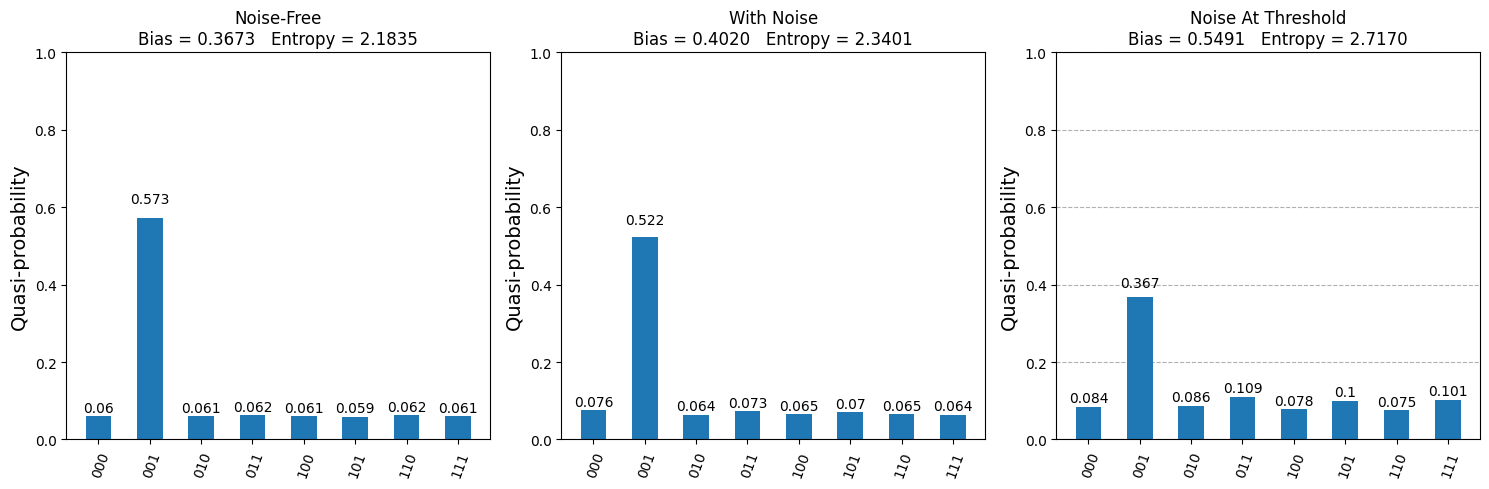

In [36]:
def grover_search(marked_states, shots=100000, noise=None):
    oracle = grover_oracle(marked_states)
    grover_op = GroverOperator(oracle)

    optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
    )
    
    qc = QuantumCircuit(grover_op.num_qubits)
    # Create even superposition of all basis states
    qc.h(range(grover_op.num_qubits))
    qc.z(0) # Bug
    qc.h(0) # Bug
    # Apply Grover operator the optimal number of times
    qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
    # Measure all qubits
    qc.measure_all()
    
    sampler = AerSimulator(method='statevector', noise_model=noise)
    target = sampler.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)

    circuit_isa = pm.run(qc)
    circuit_isa = circuit_isa.decompose(reps=10)
    result = sampler.run(circuit_isa, shots=shots, memory=True).result()
    return result.get_counts(), circuit_isa

marked_states=['000', '001']
shots = 10000
noise = create_noise_model(0.014)


result, _ = grover_search(marked_states, shots, noise=noise_model)
result_noise_free, _ = grover_search(marked_states, shots, noise=None)
result_noise_thresh, _ = grover_search(marked_states, shots, noise=noise)

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms
plot_distribution(result, ax=axes[1])
bias,entropy=calculate_bias_entropy(result,marked_states)
axes[1].set_title(f"With Noise\nBias = {bias:.4f}   Entropy = {entropy:.4f}")

plot_distribution(result_noise_free, ax=axes[0])
bias,entropy=calculate_bias_entropy(result_noise_free,marked_states)
axes[0].set_title(f"Noise-Free\nBias = {bias:.4f}   Entropy = {entropy:.4f}")

plot_distribution(result_noise_thresh, ax=axes[2])
bias,entropy=calculate_bias_entropy(result_noise_thresh,marked_states)
axes[2].set_title(f"Noise At Threshold\nBias = {bias:.4f}   Entropy = {entropy:.4f}")

axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)
axes[2].set_ylim(0, 1)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()